In [24]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import CLB.CLBXMLWriter as CLBXML   
import tempfile
import scipy.optimize as so
from display_xml import XML

from scipy.integrate import solve_ivp

# First shot: spatially variable SIR model with uniform IC

```
Zadanie E - Benchmark I: Poprawność symulacji równań typu SIR w domenie jednorodnej (0D) vs analityczne/Runge-Kutta
 - output jak do raportu/artykułu (nie do szkolenia) .md
 - dodać skrypt do examples and papers
 - dodać ref do repo :)
```
 

To evaluate, if model is working, let's start with basic case: uniform initial distribution of SIR variables, with periodic BC. This should give solution for original SIR ODE, if $\beta$ is sufficiently large.

Firstly, we prepare solution of ODE using SymPy's solve_ivp toolbox. For details see previous workshops.

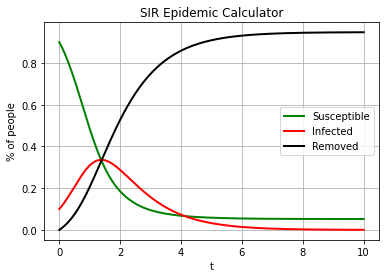

In [102]:
#Test case settings

I_init = 0.1
S_init = 1. - I_init
R_init = 0
beta = 1e20
dt = 0.01
R0 = 3
T = 1000



###########################3
# FD SOLUTION #


def SIR_0D(t, z, beta, gamma, N):
    """
     # Susceptible → Infected → Removed
    :param t: time [days]
    :param z: Susceptible, Exposed, Infected, Removed
    :param beta: average number of contacts per day for each infected individual
    :param gamma: Between I and R, the transition rate is γ
    (simply the frequency of recoveries, that is, number of recovered or dead during one day
    divided by the total number of infected on that same day, supposing "day" is the time unit).
    If the duration of the infection is denoted D, then γ = 1/D.
    :return: derivatives [dS, dI, dR]
    """

    S, I, R = z
    dSdt = -beta*I*S/N
    dIdt = beta*I*S/N - I*gamma
    dRdt = I*gamma
    return [dSdt, dIdt, dRdt]



# INITIAL CONDItIONS
initial_susceptible = S_init # initial number of susceptible individuals in population.
initial_infections = I_init  # initial number of infected individuals in population.
initial_removed = R_init  # initial number of removed (recovered) individuals in population.
IC = np.array([initial_susceptible, initial_infections, initial_removed])

days_to_simulate = T*dt
sol = solve_ivp(SIR_0D,
                [0, days_to_simulate],
                IC,
                method='RK45',
                args=[R0, 1, 1],
                dense_output=True)

t = np.linspace(0, days_to_simulate, 1000)
z = sol.sol(t)

S_rk4, I_rk4, R_rk4 = z

params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (14, 8),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
axes = plt.gca()
plt.plot(t, S_rk4,
         color="green", marker="", markevery=1, markersize=15, linestyle="-", linewidth=2,
         label='Susceptible')
plt.plot(t, I_rk4,
         color="red", marker="", markevery=1, markersize=15, linestyle="-", linewidth=2,
         label='Infected')
plt.plot(t, R_rk4,
         color="black", marker="", markevery=1, markersize=15, linestyle="-", linewidth=2,
         label='Removed')


plt.xlabel('t')
plt.ylabel('% of people')
plt.title('SIR Epidemic Calculator')
plt.legend()
plt.grid()
plt.show()



We will use **2q9_reaction_diffusion_system_SIR_ModifiedPeng** model (or the WSIR model), aleready referenced in this workshop

$$
\frac{\partial}{\partial t} W = \beta_W \left[\frac{r^2}{8}W + (I-W) \right] \\
\frac{\partial}{\partial t} S = - \beta \frac{S}{N}W\\
\frac{\partial}{\partial t} I = \beta \frac{S}{N}W - \gamma I \\
\frac{\partial}{\partial t} R = \gamma I
$$


where 

$$
S = ODE_1 \\
I = ODE_2 \\
R = ODE_3 \\
C_1 = R_0 \\
C_2 = \beta\\
C_3 = dt
$$

\begin{align}
S = ODE_1 \\
I = ODE_2 \\
R = ODE_3 \\
C_1 = R_0 \\
C_2 = \beta\\
C_3 = dt
\end{align}

$$
S = ODE_1
$$


In [103]:


CLBc = CLBXML.CLBConfigWriter( )

CLBc.addGeomParam('nx', 100)
CLBc.addGeomParam('ny', 2)


params = {
        "Diffusivity_DRE_1" : 1./6.,
        "C_1":R0,
        "C_2":beta,
        "C_3":dt,            
        "Init_DRE_1":I_init, #This is W equation, initlally equall to I. large Beta reduces Relaxation-To-SIR Time
        "Init_ODE_1":S_init,
        "Init_ODE_2":I_init,
        "Init_ODE_3":R_init
}

CLBc.addModelParams(params)


CLBc.addHDF5()
solve = CLBc.addSolve(iterations=T)
CLBc.addHDF5(Iterations=int(T / 50), parent=solve)
   
CLBc.write('run.xml')



In [107]:
! rm -rf output/* && tclb d2q9_reaction_diffusion_system_SIR_ModifiedPeng run.xml

MPMD: TCLB: local:0/1 work:0/1 ---  connected to:
[  ] -------------------------------------------------------------------------
[  ] -  CLB version:   v6.0-beta-1713-g0861a50                               -
[  ] -        Model: d2q9_reaction_diffusion_system_SIR_ModifiedPeng                 
[  ]               -
[  ] -------------------------------------------------------------------------
[  ] Setting output path to: run
[  ] Discarding 1 comments
[ 0] Running on CPU
[ 0] WARNING: No "Units" element in config file
[  ] Mesh size in config file: 100x2x1
[  ] Global lattice size: 100x2x1
[  ] Max region size: 200. Mesh size 200. Overhead:  0%
[  ] Local lattice size: 100x2x1
Hello allocator!
[  ]   Threads  |      Action
[  ]     1x1    | Primal , NoGlobals , BaseIteration
[  ]     1x1    | Tangent , NoGlobals , BaseIteration
[  ]     1x1    | Optimize , NoGlobals , BaseIteration
[  ]     1x1    | SteadyAdjoint , NoGlobals , BaseIteration
[  ]     1x1    | Primal , IntegrateGlobals , B

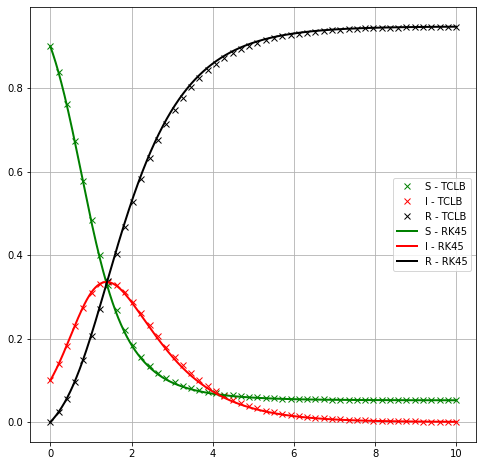

In [108]:
S = list()
I = list()
R = list()

for i in range(0,T,int(T / 50)):
    f = h5py.File('output/run_HDF5_%08d.h5'%i)    
    #plt.plot(f['DRE_1'][0,25,:])
    S.append( f['ODE_1'][0,0,0] )
    I.append( f['ODE_2'][0,0,0] )
    R.append( f['ODE_3'][0,0,0] )

t_lb = np.linspace(0,T,len(S))*dt
    
    
plt.figure(figsize=(8,8))
    
plt.plot(t_lb,S, 'gx', label='S - TCLB')
plt.plot(t_lb,I, 'rx', label='I - TCLB')
plt.plot(t_lb,R, 'kx', label='R - TCLB')

plt.plot(t, S_rk4,
         color="green", marker="", markevery=1, markersize=15, linestyle="-", linewidth=2,
         label='S - RK45')
plt.plot(t, I_rk4,
         color="red", marker="", markevery=1, markersize=15, linestyle="-", linewidth=2,
         label='I - RK45')
plt.plot(t, R_rk4,
         color="black", marker="", markevery=1, markersize=15, linestyle="-", linewidth=2,
         label='R - RK45')
plt.legend()

plt.grid(which='both')

## We could use TCLB shortcuts in a loop, to see effects of $\beta$

Hello allocator!
DONE!
Hello allocator!
DONE!
Hello allocator!
DONE!


Text(0, 0.5, '% of population')

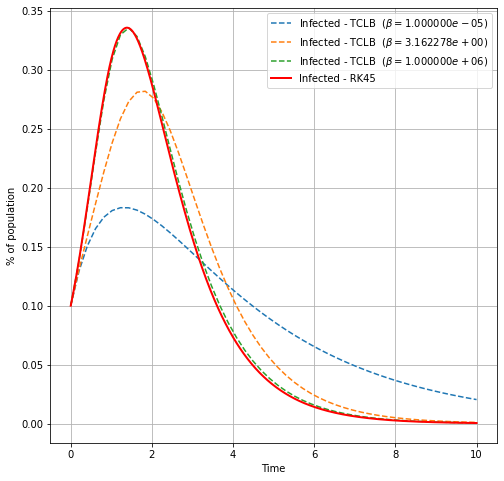

In [109]:
plt.figure(figsize=(8,8))
    
for _beta in np.logspace(-5,6,3):
    
    CLBc = CLBXML.CLBConfigWriter( )

    CLBc.addGeomParam('nx', 5)
    CLBc.addGeomParam('ny', 5)


    params = {
            "Diffusivity_DRE_1" : 1./6.,
            "C_1":R0,
            "C_2":_beta,
            "C_3":dt,            
            "Init_DRE_1":I_init, #This is W equation, initlally equall to I. large Beta reduces Relaxation-To-SIR Time
            "Init_ODE_1":S_init,
            "Init_ODE_2":I_init,
            "Init_ODE_3":R_init
    }

    CLBc.addModelParams(params)


    CLBc.addHDF5()
    solve = CLBc.addSolve(iterations=T)
    CLBc.addHDF5(Iterations=int(T / 50), parent=solve)

    CLBc.write('run.xml')

    ! rm -rf output/* &&  tclb d2q9_reaction_diffusion_system_SIR_ModifiedPeng run.xml > /dev/null && echo "DONE!"


    S = list()
    I = list()
    R = list()

    for i in range(0,T,int(T / 50)):
        f = h5py.File('output/run_HDF5_%08d.h5'%i)    
        #plt.plot(f['DRE_1'][0,25,:])
        S.append( f['ODE_1'][0,0,0] )
        I.append( f['ODE_2'][0,0,0] )
        R.append( f['ODE_3'][0,0,0] )

    t_lb = np.linspace(0,T,len(S))*dt

#    plt.plot(t_lb,S, 'g-', label=r'S - TCLB ($\beta=$)')
    plt.plot(t_lb,I, '--', label=r'Infected - TCLB  ($\beta=%e$)'%_beta )
    
#    plt.plot(t_lb,R, 'k-', label='R - TCLB')

#plt.plot(t, S_rk4,
#         color="green", marker="", markevery=1, markersize=15, linestyle="-", linewidth=2,
#         label='S - RK45')
plt.plot(t, I_rk4,
         color="red", marker="", markevery=1, markersize=15, linestyle="-", linewidth=2,
         label='Infected - RK45')
#plt.plot(t, R_rk4,
#         color="black", marker="", markevery=1, markersize=15, linestyle="-", linewidth=2,
#         label='R - RK45')
plt.legend()
plt.grid(which='both')
plt.xlabel('Time')
plt.ylabel('% of population')

# SIR - Simple Laplace
The same could be done with SIR_SimpleLaplace model - for large $\beta$ results are identical

Hello allocator!


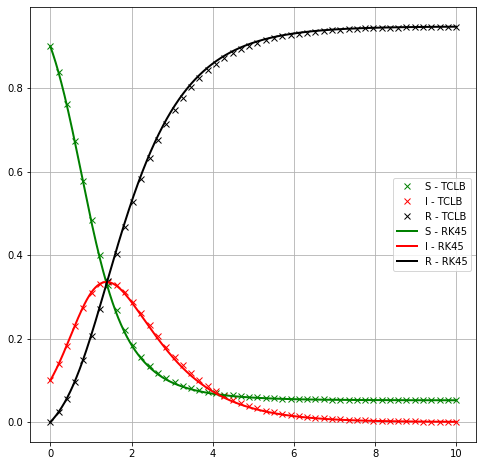

In [110]:


CLBc = CLBXML.CLBConfigWriter( )

CLBc.addGeomParam('nx', 5)
CLBc.addGeomParam('ny', 5)


params = {
        "Diffusivity_DRE_1" : 1./6.,
        "Diffusivity_DRE_2" : 1./6.,
        "Diffusivity_DRE_3" : 1./6.,    
        "C_1":R0,
        "C_2":dt, 
        "Init_DRE_1":S_init,
        "Init_DRE_2":I_init,
        "Init_DRE_3":R_init
}

CLBc.addModelParams(params)


CLBc.addHDF5()
solve = CLBc.addSolve(iterations=T)
CLBc.addHDF5(Iterations=int(T / 50), parent=solve)
   
CLBc.write('run.xml')

! rm -rf output/* &&  tclb d2q9_reaction_diffusion_system_SIR_SimpleLaplace run.xml > /dev/null


S = list()
I = list()
R = list()

for i in range(0,T,int(T / 50)):
    f = h5py.File('output/run_HDF5_%08d.h5'%i)    
    #plt.plot(f['DRE_1'][0,25,:])
    S.append( f['DRE_1'][0,0,0] )
    I.append( f['DRE_2'][0,0,0] )
    R.append( f['DRE_3'][0,0,0] )

t_lb = np.linspace(0,T,len(S))*dt
    
    
plt.figure(figsize=(8,8))
    
plt.plot(t_lb,S, 'gx', label='S - TCLB')
plt.plot(t_lb,I, 'rx', label='I - TCLB')
plt.plot(t_lb,R, 'kx', label='R - TCLB')

plt.plot(t, S_rk4,
         color="green", marker="", markevery=1, markersize=15, linestyle="-", linewidth=2,
         label='S - RK45')
plt.plot(t, I_rk4,
         color="red", marker="", markevery=1, markersize=15, linestyle="-", linewidth=2,
         label='I - RK45')
plt.plot(t, R_rk4,
         color="black", marker="", markevery=1, markersize=15, linestyle="-", linewidth=2,
         label='R - RK45')
plt.legend()

plt.grid(which='both')


# Simple spatially variable SIR model with non-uniform IC